In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
from keras import optimizers
import keras_metrics as km # for precsion/ recall metrics
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
# callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


from sklearn.model_selection import train_test_split

import glob
import json
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import zoom

# for openvino
import tensorflow as tf

Using TensorFlow backend.
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/ana

In [2]:
#%%
from data_generator_sx3 import SX3Dataset
from data_generator import CorrDatasetV2
from model import Model, Model10, Model8, Model4
from utils import save_model#, load_model

In [3]:
import autoreload
%load_ext autoreload
%autoreload 2

### Load data

In [4]:
def load_data(discr):
    '''prepare data generator data '''
    global_path_mp_i = 'synth_data/discr_{}/mp/*_i_*'.format(discr)
    global_path_mp_q = 'synth_data/discr_{}/mp/*_q_*'.format(discr)
    global_path_nomp_i = 'synth_data/discr_{}/no_mp/*_i_*'.format(discr)
    global_path_nomp_q = 'synth_data/discr_{}/no_mp/*_q_*'.format(discr)
    paths_mp_i = sorted(glob.glob(global_path_mp_i))
    paths_mp_q = sorted(glob.glob(global_path_mp_q))
    paths_nomp_i = sorted(glob.glob(global_path_nomp_i))
    paths_nomp_q = sorted(glob.glob(global_path_nomp_q))

    synth_data_samples = []
    synth_data_labels = []
    for path_mp_i, path_mp_q in zip(paths_mp_i, paths_mp_q):
        matr_i = pd.read_csv(path_mp_i, sep=',', header=None).values
        matr_q = pd.read_csv(path_mp_q, sep=',', header=None).values
        matr_i = matr_i[...,None]
        matr_q = matr_q[...,None]
        matr = np.concatenate((matr_i, matr_q), axis=2)
        #matr = matr_i**2 + matr_q**2
        synth_data_samples.append(matr)
        synth_data_labels.append(1)

    for path_nomp_i, path_nomp_q in zip(paths_nomp_i, paths_nomp_q):
        matr_i = pd.read_csv(path_nomp_i, sep=',', header=None).values
        matr_q = pd.read_csv(path_nomp_q, sep=',', header=None).values
        matr_i = matr_i[...,None]
        matr_q = matr_q[...,None]
        matr = np.concatenate((matr_i, matr_q), axis=2)
        #matr = matr_i**2 + matr_q**2
        synth_data_samples.append(matr)
        synth_data_labels.append(0)

    synth_data_samples = np.array(synth_data_samples)
    synth_data_labels = np.array(synth_data_labels)

    X_train_synth, X_val_synth, y_train_synth, y_val_synth = train_test_split(synth_data_samples, synth_data_labels, test_size=0.2, shuffle=True)
    
    return X_train_synth, X_val_synth, y_train_synth, y_val_synth

In [5]:
#print(X_train_synth.shape)
##temp = cv2.resize(X_train_synth, (3,40,40,2))plt.imshow(temp[0,...,0])
#temp = zoom(X_train_synth, zoom=(1,0.2,0.2,1))
#print(temp.shape)
#plt.imshow(temp[0,...,0])
#plt.show()
#plt.imshow(X_train_synth[0,...,0])
#plt.show()

### Build, train, save model

In [18]:
batch_size = 32
train_iters = 5
learning_rate = 1e-4

In [33]:
#%% Define model.
models_mp, h5_paths = [], []
shapes = [(80,80,2), (60,60,2), (40,40,2), (20,20,2), (10,10,2)]
for shape in shapes:
    h5_paths.append('saved_models/best_model/best_mp_model{}.h5'.format(shape[0]))
    if shape[1] in [20, 40, 60, 80]:
        models_mp.append(Model(shape=shape))
    elif shape[1] == 10:
        models_mp.append(Model10(shape=(shape)))

In [34]:
shapes, h5_paths, models_mp

([(80, 80, 2), (60, 60, 2), (40, 40, 2), (20, 20, 2), (10, 10, 2)],
 ['saved_models/best_model/best_mp_model80.h5',
  'saved_models/best_model/best_mp_model60.h5',
  'saved_models/best_model/best_mp_model40.h5',
  'saved_models/best_model/best_mp_model20.h5',
  'saved_models/best_model/best_mp_model10.h5'],
  <model.Model10 at 0x7f4b72992190>])

In [35]:
X_vals, y_vals = [], []
histories = dict()
for model, h5_path, shape in zip(models_mp, h5_paths, shapes):   
    # load data
    discr = shape[0]
    X_train_synth, X_val_synth, y_train_synth, y_val_synth = load_data(discr)
    # keep X_vals/ y_vals for inference
    X_vals.append(X_val_synth)
    y_vals.append(y_val_synth)
    
    # define augmentatios
    datagen = ImageDataGenerator(
            #featurewise_center=True,
            #featurewise_std_normalization=True,
            #rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            #horizontal_flip=True
            )
    datagen.fit(X_train_synth)
    
    # define call backs
    checkpointer = ModelCheckpoint(filepath=h5_path, verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau()
    early_stopping = EarlyStopping(patience=5, min_delta=0.0001)
    
    model.model.compile(loss='binary_crossentropy',
                        optimizer=optimizers.Adam(lr=learning_rate),
                        metrics=['acc',
                               km.binary_precision(),
                               km.binary_recall()])

    #%% Train model: pretrain on data gen
    history = model.model.fit_generator(
        datagen.flow(X_train_synth, y_train_synth, batch_size=batch_size),
        validation_data=(X_val_synth, y_val_synth),
        epochs=train_iters,
        callbacks=[reduce_lr, early_stopping, checkpointer]
        )
    
    histories[shape[0]] = history
#save_model(model.model, 'saved_models/sc1_data_gen_train_zoom.pkl')    

# load model from .h5
#model.model = load_model('saved_models/sc1_data_gen_train.pkl')
#model.model = load_model('saved_models/sc2_fine_tune.pkl')

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (560, 80, 80, 2) (2 channels).
  ' channels).')


tracking <tf.Variable 'Variable_12:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_13:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_14:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_15:0' shape=() dtype=int32> fn


/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (560, 80, 80, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/5
70/70 [==============================] - 21s 299ms/step - loss: 0.6765 - acc: 0.5339 - precision: 0.4794 - recall: 0.4710 - val_loss: 0.6120 - val_acc: 0.8643 - val_precision: 1.0000 - val_recall: 0.7576

Epoch 00001: val_loss improved from inf to 0.61203, saving model to saved_models/best_model/best_mp_model80.h5
Epoch 2/5
70/70 [==============================] - 20s 280ms/step - loss: 0.5578 - acc: 0.7750 - precision: 0.8155 - recall: 0.6546 - val_loss: 0.4079 - val_acc: 0.8357 - val_precision: 0.8149 - val_recall: 0.8959

Epoch 00002: val_loss improved from 0.61203 to 0.40786, saving model to saved_models/best_model/best_mp_model80.h5
Epoch 3/5
70/70 [==============================] - 22s 320ms/step - loss: 0.4283 - acc: 0.8071 - precision: 0.7920 - recall: 0.8174 - val_loss: 0.3049 - val_acc: 0.8786 - val_precision: 1.0000 - val_recall: 0.7183

Epoch 00003: val_loss improved from 0.40786 to 0.30495, saving model to saved_models/best_model/best_mp_model80.h5
Epoch 4/5
70/7

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (560, 60, 60, 2) (2 channels).
  ' channels).')


tracking <tf.Variable 'Variable_16:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_17:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_18:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_19:0' shape=() dtype=int32> fn


/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (560, 60, 60, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/5
70/70 [==============================] - 13s 185ms/step - loss: 0.6739 - acc: 0.5804 - precision: 0.3759 - recall: 0.2710 - val_loss: 0.6089 - val_acc: 0.7660 - val_precision: 1.0000 - val_recall: 0.5889

Epoch 00001: val_loss improved from inf to 0.60888, saving model to saved_models/best_model/best_mp_model60.h5
Epoch 2/5
70/70 [==============================] - 12s 165ms/step - loss: 0.5344 - acc: 0.7696 - precision: 0.7252 - recall: 0.8313 - val_loss: 0.3332 - val_acc: 0.9007 - val_precision: 1.0000 - val_recall: 0.8281

Epoch 00002: val_loss improved from 0.60888 to 0.33325, saving model to saved_models/best_model/best_mp_model60.h5
Epoch 3/5
70/70 [==============================] - 11s 154ms/step - loss: 0.3598 - acc: 0.8482 - precision: 0.8616 - recall: 0.8497 - val_loss: 0.3286 - val_acc: 0.8723 - val_precision: 1.0000 - val_recall: 0.7922

Epoch 00003: val_loss improved from 0.33325 to 0.32857, saving model to saved_models/best_model/best_mp_model60.h5
Epoch 4/5
70/7

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (560, 40, 40, 2) (2 channels).
  ' channels).')


tracking <tf.Variable 'Variable_20:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_21:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_22:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_23:0' shape=() dtype=int32> fn


/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (560, 40, 40, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/5
70/70 [==============================] - 6s 91ms/step - loss: 0.6878 - acc: 0.5857 - precision: 0.4866 - recall: 0.3054 - val_loss: 0.6651 - val_acc: 0.6286 - val_precision: 0.6012 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 0.66511, saving model to saved_models/best_model/best_mp_model40.h5
Epoch 2/5
70/70 [==============================] - 5s 74ms/step - loss: 0.6442 - acc: 0.6625 - precision: 0.5660 - recall: 0.8857 - val_loss: 0.5724 - val_acc: 0.6786 - val_precision: 1.0000 - val_recall: 0.3588

Epoch 00002: val_loss improved from 0.66511 to 0.57236, saving model to saved_models/best_model/best_mp_model40.h5
Epoch 3/5
70/70 [==============================] - 5s 70ms/step - loss: 0.5182 - acc: 0.7696 - precision: 0.7787 - recall: 0.7052 - val_loss: 0.3213 - val_acc: 0.9429 - val_precision: 0.9928 - val_recall: 0.9106

Epoch 00003: val_loss improved from 0.57236 to 0.32133, saving model to saved_models/best_model/best_mp_model40.h5
Epoch 4/5
70/70 [===

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (560, 20, 20, 2) (2 channels).
  ' channels).')


tracking <tf.Variable 'Variable_24:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_25:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_26:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_27:0' shape=() dtype=int32> fn


/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (560, 20, 20, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/5
70/70 [==============================] - 3s 39ms/step - loss: 0.6946 - acc: 0.4429 - precision: 0.4194 - recall: 0.4230 - val_loss: 0.6916 - val_acc: 0.4786 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.69161, saving model to saved_models/best_model/best_mp_model20.h5
Epoch 2/5
70/70 [==============================] - 1s 21ms/step - loss: 0.6908 - acc: 0.5107 - precision: 0.7229 - recall: 0.0406 - val_loss: 0.6864 - val_acc: 0.5000 - val_precision: 1.0000 - val_recall: 0.0920

Epoch 00002: val_loss improved from 0.69161 to 0.68636, saving model to saved_models/best_model/best_mp_model20.h5
Epoch 3/5
70/70 [==============================] - 1s 20ms/step - loss: 0.6872 - acc: 0.6071 - precision: 0.6779 - recall: 0.4168 - val_loss: 0.6775 - val_acc: 0.5143 - val_precision: 1.0000 - val_recall: 0.1214

Epoch 00003: val_loss improved from 0.68636 to 0.67751, saving model to saved_models/best_model/best_mp_model20.h5
Epoch 4/5
70

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (560, 10, 10, 2) (2 channels).
  ' channels).')


tracking <tf.Variable 'Variable_28:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_29:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_30:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_31:0' shape=() dtype=int32> fn


/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (560, 10, 10, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/5
70/70 [==============================] - 3s 40ms/step - loss: 0.6915 - acc: 0.5089 - precision: 0.4901 - recall: 0.6418 - val_loss: 0.6928 - val_acc: 0.4857 - val_precision: 0.9444 - val_recall: 0.0836

Epoch 00001: val_loss improved from inf to 0.69283, saving model to saved_models/best_model/best_mp_model10.h5
Epoch 2/5
70/70 [==============================] - 1s 13ms/step - loss: 0.6906 - acc: 0.5214 - precision: 0.6248 - recall: 0.1246 - val_loss: 0.6938 - val_acc: 0.4643 - val_precision: 0.6111 - val_recall: 0.0189

Epoch 00002: val_loss did not improve from 0.69283
Epoch 3/5
70/70 [==============================] - 1s 14ms/step - loss: 0.6862 - acc: 0.5393 - precision: 0.6991 - recall: 0.1485 - val_loss: 0.6923 - val_acc: 0.4786 - val_precision: 0.8889 - val_recall: 0.0489

Epoch 00003: val_loss improved from 0.69283 to 0.69231, saving model to saved_models/best_model/best_mp_model10.h5
Epoch 4/5
70/70 [==============================] - 1s 14ms/step - loss: 0.6821 - acc

In [43]:
list(zip(discrs, val_acc, val_pr, val_recall))

[(80, 0.8642857074737549, 1.0, 0.7576301693916321),
 (80, 0.8357142806053162, 0.8148764967918396, 0.8958790302276611),
 (80, 0.8785714507102966, 1.0, 0.7183433771133423),
 (80, 0.8857142925262451, 1.0, 0.7279117107391357),
 (80, 0.9071428775787354, 1.0, 0.7830063700675964),
 (60, 0.7659574747085571, 1.0, 0.5889298319816589),
 (60, 0.9007092118263245, 1.0, 0.8280631303787231),
 (60, 0.8723404407501221, 1.0, 0.7922391295433044),
 (60, 0.8936170339584351, 1.0, 0.8168565034866333),
 (60, 0.9007092118263245, 1.0, 0.8264291286468506),
 (40, 0.6285714507102966, 0.6012404561042786, 1.0),
 (40, 0.6785714030265808, 1.0, 0.3588198721408844),
 (40, 0.9428571462631226, 0.9928166270256042, 0.9106314182281494),
 (40, 0.7571428418159485, 1.0, 0.5235478281974792),
 (40, 0.8714285492897034, 1.0, 0.6745319366455078),
 (20, 0.47857141494750977, 0.0, 0.0),
 (20, 0.5, 0.9999998807907104, 0.09198414534330368),
 (20, 0.5142857432365417, 1.0, 0.12137358635663986),
 (20, 0.4928571283817291, 0.9999998807907104, 

In [46]:
val_acc, val_pr, val_recall, discrs = [], [], [], []
for key, value in histories.items():
    discrs += [key] * 5
    val_acc += value.history['val_acc']
    val_pr += value.history['val_precision']
    val_recall += value.history['val_recall']
 
metrics = pd.DataFrame(list(zip(discrs, val_acc, val_pr, val_recall)), columns=['discr', 'vall_acc', 'val_pr', 'val_recall'])
metrics.to_csv('metrics.csv')

,discr,vall_acc,val_pr,val_recall
0,80,0.864286,1.000000,0.757630
1,80,0.835714,0.814876,0.895879
2,80,0.878571,1.000000,0.718343
3,80,0.885714,1.000000,0.727912
4,80,0.907143,1.000000,0.783006
5,60,0.765957,1.000000,0.588930
6,60,0.900709,1.000000,0.828063
7,60,0.872340,1.000000,0.792239
8,60,0.893617,1.000000,0.816857
9,60,0.900709,1.000000,0.826429


In [51]:
metrics.groupby('discr').max().round(3)

,vall_acc,val_pr,val_recall
discr,,,
10,0.486,0.944,0.084
20,0.757,1.000,0.641
40,0.943,1.000,1.000
60,0.901,1.000,0.828
80,0.907,1.000,0.896


In [ ]:
metrics = pd.DataFrame(columns)

In [29]:
discr = [shape[0]] * 5
discr + [shape[0]] * 5

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]

In [26]:
history.history['val_acc']

[0.9214285612106323,
 0.8999999761581421,
 0.9357143044471741,
 0.9357143044471741,
 0.949999988079071]

### Convert Keras model .h5 to TF frozen graph .pb

In [10]:
from convert_ir_model import IRModel

In [51]:
ir_models = []
for model, h5_path, shape in zip(models_mp, h5_paths, shapes):
    tf_path = 'tf_mp_model{}.pb'.format(shape[0])
    ir_model = IRModel(h5_path, tf_path)
    ir_model.build_tf_graph()
    
    # convert tensorflow graph to ir_model (from terminal or bash)
    if shape[0] == 80:
        ! chmod 744 /saved_models/convert_tf_ncs2_80.sh
        ! ./saved_models/convert_tf_ncs2_80.sh
    elif shape[0] == 60:
        ! chmod 744 /saved_models/convert_tf_ncs2_60.sh
        ! ./saved_models/convert_tf_ncs2_60.sh
    elif shape[0] == 40:
        ! chmod 744 /saved_models/convert_tf_ncs2_40.sh
        ! ./saved_models/convert_tf_ncs2_40.sh
    elif shape[0] == 20:
        ! chmod 744 /saved_models/convert_tf_ncs2_20.sh
        ! ./saved_models/convert_tf_ncs2_20.sh
    elif shape[0] == 10:
        ! chmod 744 /saved_models/convert_tf_ncs2_10.sh
        ! ./saved_models/convert_tf_ncs2_10.sh

tracking <tf.Variable 'Variable_120:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_121:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_122:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_123:0' shape=() dtype=int32> fn
INFO:tensorflow:Froze 2177 variables.
INFO:tensorflow:Converted 2177 variables to const ops.
chmod: cannot access '/saved_models/convert_tf_ncs2_80.sh': No such file or directory
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/tf_model/tf_mp_model80.pb
	- Path for generated IR: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/ir_model
	- IR output name: 	ir_model80
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,80,80,2]
	- Mean values: 	Not specified
	- Scale va

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/anaconda

tracking <tf.Variable 'Variable_132:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_133:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_134:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_135:0' shape=() dtype=int32> fn
INFO:tensorflow:Froze 2366 variables.
INFO:tensorflow:Converted 2366 variables to const ops.
chmod: cannot access '/saved_models/convert_tf_ncs2_20.sh': No such file or directory
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/tf_model/tf_mp_model20.pb
	- Path for generated IR: 	/home/evgenii/Documents/01_These/gnss_signal_generator/saved_models/ir_model
	- IR output name: 	ir_model20
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,20,20,2]
	- Mean values: 	Not specified
	- Scale va

/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/evgenii/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/evgenii/anaconda

### Convert TF .pb to IR model

### Make inference on NCS2

In [55]:
for img in X_val_synth:
    print(img.shape)
    break

(10, 10, 2)


In [61]:
prepimg.shape

(1, 2, 80, 80)

In [66]:
# run inference on NCS2
import cv2
import sys
import os
import logging as log
from time import time
from openvino.inference_engine import IENetwork, IEPlugin

# runtime
runtime = dict()

for shape, X_val, y_val in zip(shapes, X_vals, y_vals):
    for img, label in zip(X_val[:30], y_val[:30]):
        log.basicConfig(format='[ %(levelname)s ] %(message)s', level=log.INFO, stream=sys.stdout)
        model_xml_path = 'saved_models/ir_model/ir_model{}.xml'.format(shape[0]) # model
        model_bin_path = 'saved_models/ir_model/ir_model{}.bin'.format(shape[0]) # weights

        # plugin initialization for specified device
        plugin = IEPlugin(device='MYRIAD')

        # read ir model
        log.info('loading network files: \n\t{}\n\t{}'.format(model_xml_path, model_bin_path))
        net = IENetwork(model=model_xml_path, weights=model_bin_path)

        log.info('Preparing input blobs')
        input_blob = next(iter(net.inputs))
        out_blob = next(iter(net.outputs))

        # prepare image
        # get shapes
        n, c, h, w = net.inputs[input_blob].shape
        log.info('required img shape:  {},{},{},{}'.format(n, c, h, w))
        prepimg = np.ndarray(shape=(n, c, h, w))

        # change data layout from HW to NCHW
        img = img[None,...]
        prepimg[0,0,:,:] = np.moveaxis(img, -1, 0)[0,:]
        log.info('prepimg shape:  {},{},{},{}'.format(prepimg.shape[0], prepimg.shape[1], 
                                                      prepimg.shape[2], prepimg.shape[3]))

        # loading model to plugin
        log.info('Loading model to the plugin')
        exec_net = plugin.load(network=net)
        del net

        # start sync inference
        log.info('Starting inference ({} iterations)'.format(1))
        infer_time = []
        t0 = time()
        res = exec_net.infer(inputs={input_blob: prepimg})

        infer_time.append((time() - t0) * 1000)
        log.info('Average running time of one iteration: {} ms'.format(np.average(np.asarray(infer_time))))

        # processing output blob
        log.info('Processing output blob')
        pred_probas = res[out_blob]
        # convert probas into labels
        preds = (pred_probas > 0.5).astype(int)
        #print(ind, pred_probas, preds, y_train_sx[ind])
        print('compare pred: ', pred_probas, preds, label)
        print
        
        # log runtime
        if shape[0] in runtime.keys():
            runtime[shape[0]].append(infer_time[0])
        else:
            runtime[shape[0]] = [infer_time[0]]
        
        print(runtime)
        print('---------------------------------------')
        
        # del plugin to make inference next time
        del exec_net
        del plugin

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 12.375831604003906 ms
[ INFO ] Processing output blob
compare pred:  [[0.26831055]] [[0]] 0
{80: [12.375831604003906]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.590864181518555 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555]}
--------------------------

[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.258508682250977 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 13.34524154663086 ms
[ INFO ] Processing output blob
compare pred:  [[0.7788086]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605

[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2,80,80
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 5.996942520141602 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model80.xml
	saved_models/ir_model/ir_model80.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,80,80
[ INFO ] prepimg shape:  1,2

[ INFO ] Average running time of one iteration: 6.471872329711914 ms
[ INFO ] Processing output blob
compare pred:  [[0.92333984]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepi

compare pred:  [[0.8540039]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.907224655151367, 3.7097930908203125, 3.7076473236083984, 3.378152847290039, 11.40141487121582]}
---------------------------------------
[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required im

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.793975830078125 ms
[ INFO ] Processing output blob
compare pred:  [[0.8676758]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 10.386943817138672 ms
[ INFO ] Processing output blob
compare pred:  [[0.9116211]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model60.xml
	saved_models/ir_model/ir_model60.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,60,60
[ INFO ] prepimg shape:  1,2,60,60
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.833770751953125 ms
[ INFO ] Processing output blob
compare pred:  [[0.6455078]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 9.902238845825195 ms
[ INFO ] Processing output blob
compare pred:  [[0.4453125]] [[0]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.487752914428711 ms
[ INFO ] Processing output blob
compare pred:  [[0.6464844]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 8.867025375366211 ms
[ INFO ] Processing output blob
compare pred:  [[0.7714844]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.7952194213867188 ms
[ INFO ] Processing output blob
compare pred:  [[0.3095703]] [[0]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.805658340454102 ms
[ INFO ] Processing output blob
compare pred:  [[0.61083984]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.90722465

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.0744075775146484 ms
[ INFO ] Processing output blob
compare pred:  [[0.57421875]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model40.xml
	saved_models/ir_model/ir_model40.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,40,40
[ INFO ] prepimg shape:  1,2,40,40
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.023313522338867 ms
[ INFO ] Processing output blob
compare pred:  [[0.7836914]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.992319107055664 ms
[ INFO ] Processing output blob
compare pred:  [[0.5175781]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.643585205078125 ms
[ INFO ] Processing output blob
compare pred:  [[0.50439453]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.8781890869140625 ms
[ INFO ] Processing output blob
compare pred:  [[0.515625]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.766132354736328 ms
[ INFO ] Processing output blob
compare pred:  [[0.51464844]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 3.8909912109375 ms
[ INFO ] Processing output blob
compare pred:  [[0.5229492]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44984

[ INFO ] Average running time of one iteration: 2.389192581176758 ms
[ INFO ] Processing output blob
compare pred:  [[0.5131836]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603515625], 60: [6.438255310058594, 6.471872329711914, 12.850284576416016, 6.863832473754883, 6.907224655151367, 3.7097930908203125, 3.7076473236083984, 3.378152847290039, 11.40141487121582, 15.936136245727539, 3.904581069946289, 3.516674041748047, 3.4651756286621094, 3.4170150756835938, 4.

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 5.726099014282227 ms
[ INFO ] Processing output blob
compare pred:  [[0.51708984]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model20.xml
	saved_models/ir_model/ir_model20.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,20,20
[ INFO ] prepimg shape:  1,2,20,20
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 7.809162139892578 ms
[ INFO ] Processing output blob
compare pred:  [[0.51953125]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.640962600708008 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.4498443603

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.6640892028808594 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.5649070739746094 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.64739990234375 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44984436035

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 6.662845611572266 ms
[ INFO ] Processing output blob
compare pred:  [[0.5019531]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.9516220092773438 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.901409149169922 ms
[ INFO ] Processing output blob
compare pred:  [[0.5107422]] [[1]] 0
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.4836063385009766 ms
[ INFO ] Processing output blob
compare pred:  [[1.]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.449844360

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 4.103183746337891 ms
[ INFO ] Processing output blob
compare pred:  [[0.50683594]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

[ INFO ] loading network files: 
	saved_models/ir_model/ir_model10.xml
	saved_models/ir_model/ir_model10.bin
[ INFO ] Preparing input blobs
[ INFO ] required img shape:  1,2,10,10
[ INFO ] prepimg shape:  1,2,10,10
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference (1 iterations)
[ INFO ] Average running time of one iteration: 2.6488304138183594 ms
[ INFO ] Processing output blob
compare pred:  [[0.5083008]] [[1]] 1
{80: [12.375831604003906, 9.590864181518555, 5.923986434936523, 4.923820495605469, 8.114099502563477, 12.37630844116211, 4.398584365844727, 12.617826461791992, 4.869222640991211, 5.707502365112305, 6.272315979003906, 4.194498062133789, 5.376338958740234, 9.258508682250977, 13.34524154663086, 13.525247573852539, 5.23686408996582, 4.624605178833008, 4.558563232421875, 4.559993743896484, 4.7740936279296875, 5.721807479858398, 4.653692245483398, 5.996942520141602, 4.729509353637695, 12.678146362304688, 4.683494567871094, 4.655599594116211, 10.294437408447266, 4.44

### Visulalize runtime visu

In [67]:
runtime_df = pd.DataFrame(runtime)
runtime_df.head()

,80,60,40,20,10
0,12.375832,6.438255,3.144503,3.798962,2.356291
1,9.590864,6.471872,3.082991,10.672808,2.908707
2,5.923986,12.850285,9.902239,2.406120,2.640963
3,4.923820,6.863832,8.731127,3.992319,2.920628
4,8.114100,6.907225,4.550219,2.602339,2.764940


In [57]:
#runtime_df.to_csv('runtime_df.csv')
runtime_df = pd.read_csv('runtime_df.csv',)
runtime_df.drop(['Unnamed: 0'], inplace=True, axis=1)

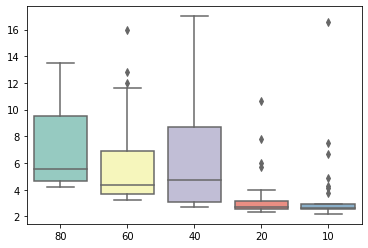

In [59]:
import seaborn as sns
sns.boxplot(data=runtime_df, palette='Set3')

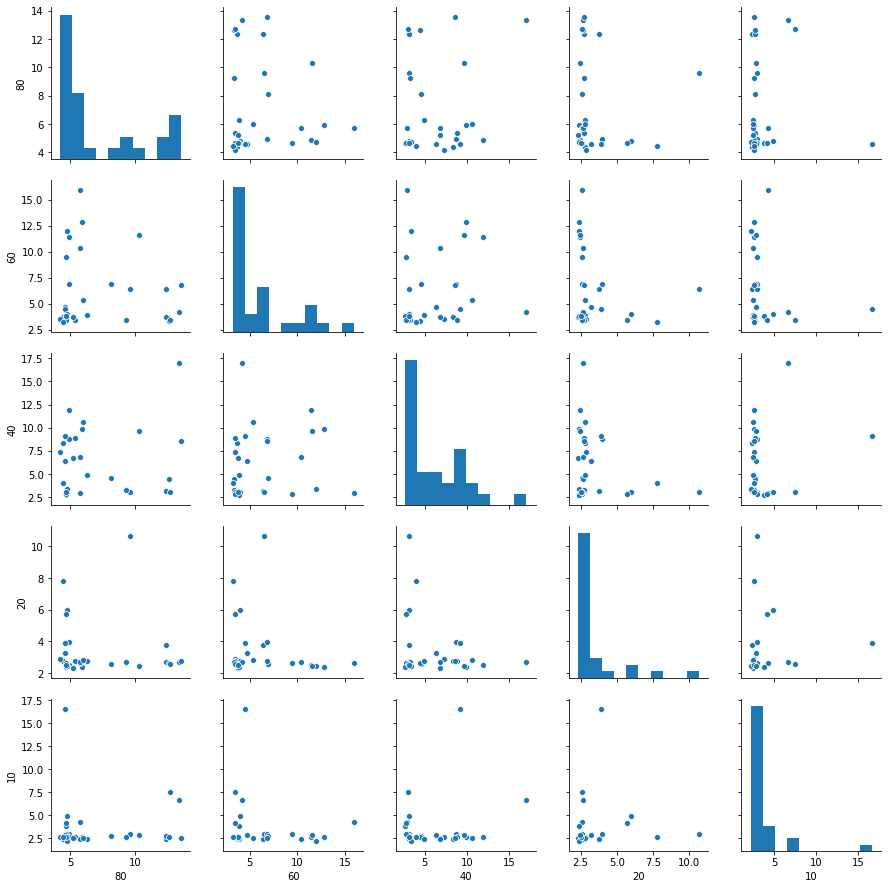

In [70]:
sns.pairplot(data=runtime_df)

### Make inference on runtime

In [71]:
from scipy import stats
import itertools

# check normality of each column. Use Shapiro-Wilk test
for col in runtime_df.columns:
    print(col, stats.shapiro(runtime_df[col]))

80 (0.7697463035583496, 1.9307588445371948e-05)
60 (0.79176926612854, 4.658263787860051e-05)
40 (0.8539572954177856, 0.0007512029260396957)
20 (0.5796531438827515, 4.157251964898023e-08)
10 (0.466134250164032, 2.392478881674265e-09)


Runtime distribution is significantly not normal. Need to do not parametric Mann-Whitney U-test with no consideration about the law af distributions:
- H0: sample distributions are equal
- H1: sample distributions are not equal

In [80]:
for left_col, right_col in itertools.combinations(['80', '60', '40'], r=2):
    print(left_col, right_col, stats.mannwhitneyu(runtime_df[left_col], runtime_df[right_col]))

80 60 MannwhitneyuResult(statistic=303.0, pvalue=0.015158714406655012)
80 40 MannwhitneyuResult(statistic=326.0, pvalue=0.033934430409721626)
60 40 MannwhitneyuResult(statistic=392.0, pvalue=0.19763350566655835)


- Sample distributions of (80, 60) and (80, 40) are significantly not equal
- Sample distributions of (60, 40) are significantly equal

In [82]:
for left_col, right_col in itertools.combinations(['40', '20', '10'], r=2):
    print(left_col, right_col, stats.mannwhitneyu(runtime_df[left_col], runtime_df[right_col]))

40 20 MannwhitneyuResult(statistic=139.0, pvalue=2.210248431604142e-06)
40 10 MannwhitneyuResult(statistic=136.0, pvalue=1.7854004393958114e-06)
20 10 MannwhitneyuResult(statistic=432.0, pvalue=0.3979227712332275)


- Sample distributions of (40, 20) and (40, 10) are significantly not equal
- Sample distributions of (20, 10) are significantly equal